# Natural Language Processing  - Jupyter Notebook
### Cecilia, Conor, Francesco 
December 2019

# Importation of packages

Best practice: create a new python virtual environemnt and run the setup.py file provided in the project repository. Then run the notebook using the virtual environment. This should install everything required.

This project requires the modules found in the Requirements.txt file, which can be installed directly onto the current python installation via eg pip install -r Requirements.txt. It also requires the spacy model "en_core_web_sm" which can be installed via python -m spacy download en_core_web_sm after spacy in installed.

Anaconda installation may differ. In particular "conda forge install textacy" install of "pip install textacy".

This script should be run from the root of the project directory.

In [1]:
import copy
from gensim.models import word2vec
import itertools
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tag import StanfordNERTagger
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import cluster, metrics
from sklearn import neighbors, datasets
from sklearn.cluster import KMeans
import snowballstemmer
import spacy
from string import ascii_lowercase
import textacy
import json

This project also requires a jdk installation. Below are examples for MacOS and Windows. Edit this cell with a path to your jdk installation.

In [2]:
# Enter your username in here. I've put the paths you wrote as an attribute in the dictionary below
user = 'Conor'

# Dictionary containing the Java paths for each user
java_paths = {
    'Conor': '/usr/lib/jvm/java-8-openjdk-amd64',
    'Francesco': '/Users/macbookpro/Downloads/jdk-13.0.1.jdk/Contents/Home/bin/java',
    'Cecilia': 'C:/Program Files/Java/jdk-13.0.1/bin/java.exe'
}

java_path = java_paths[user]

os.environ['JAVAHOME'] = java_path

# Importing and Cleaning the data

In [3]:
tickers = pd.read_json('data/word_vectors/SP500_Tickers.json', typ='series')

header = pd.read_csv('headline_scraping/full_headlines.csv', sep = ",")
header = header.drop_duplicates('Headline')
header[(header['Date']=='31/10/19') & (header['Headline'].str.contains('goods rivals'))].loc[41725,'Headline']
header

,Unnamed: 0,Headline,Date,Provider
0,0,"​ UDAY states see Rs 11,989-crore drop in inte...",20/03/17,Economic Times India
1,1,Income Tax India: 1 taxpayer owes 11% of India...,24/01/17,Economic Times India
2,2,$10 billion unhedged gap in foreign exchange d...,17/10/16,Economic Times India
3,3,10% cost reduction can add $5.5 billion to Ind...,19/01/17,Economic Times India
5,5,​10% ethanol blending can save $1.7 billion in...,11/08/15,Economic Times India
...,...,...,...,...
65587,67548,Sir Sandy Crombie to join RBS board | The Inde...,23/05/09,The Independent
65588,67549,'We had a lot of fun': Sir Stephen Nickell ref...,25/01/17,The Independent
65589,67550,Sir Tom calls time on Dobbies interest | The I...,21/05/08,The Independent
65590,67551,Sir Victor Blank joins list for M&amp;S chairm...,16/05/10,The Independent


In [4]:
# Get a list of words to not include in headlines (improves SVO extraction accuracy)
stemmer = snowballstemmer.EnglishStemmer()
stop = stopwords.words('english')
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist)))

In [5]:
# remove characters and stoplist words, then generate dictionary of unique words
data = header

data['Original_Headline'] = data['Headline']
data['Headline'].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\$&]','',inplace=True,regex=True)

extensions_list = ['usd', 'eur', 'gbp', 'reuters','Reuters','bloomberg', 'may','also','could','would', 'na','&amp','gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase)

stop = stop.union(set(extensions_list))

wordlist = filter(None, " ".join(list(set(list(itertools.chain(*data['Headline'].str.split(' ')))))).split(" "))

data['Headline'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in data['Headline'].str.lower().str.split(' ')]

header = data

In [6]:
ticker = tickers.to_frame('Ticker').reset_index()
ticker.columns=['Name','Ticker']
ticker

,Name,Ticker
0,AGILENT TECHNOLOGIES,A
1,AMERICAN AIRLINES,AAL
2,ADVANCE AUTO PARTS,AAP
3,APPLE,AAPL
4,ABBVIE,ABBV
...,...,...
495,XYLEM,XYL
496,YUM! BRANDS,YUM
497,ZIMMER BIOMET HOLDINGS,ZBH
498,ZIONS BANCORPORATION NA,ZION


In [7]:
# Create a list of all the words/tickers of the company's names in the S&P500 
#In order to select only the headlines that concern the S&P500 companies. 

company_names = ticker['Name'].to_list()
ticker_list = ticker['Ticker'].to_list()

company_regex = str1 = '|'.join(company_names).lower()
company_regex = company_regex.replace( '&', ' ',)
company_regex = company_regex.replace( '   ', '&',)
company_regex = company_regex.replace( '  ', '&',)
company_regex = company_regex.replace( ' ', '&',)
company_regex = company_regex.replace( '-', '&',)

print(company_regex)

agilent&technologies|american&airlines|advance&auto&parts|apple|abbvie|amerisourcebergen|abiomed|abbott&laboratories|accenture|adobe|analog&devices|archer&daniels&midland|automatic&data&processing|alliance&data&systems|autodesk|ameren|american&electric&power|aes|aflac|allergan|american&international|apartment&investment&management|assurant|arthur&j&gallagher&|akamai&technologies|albemarle|align&technology|alaska&air|allstate|allegion|alexion&pharmaceuticals|applied&materials|amcor|advanced&micro&devices|ametek|affiliated&managers|amgen|ameriprise&financial|american&tower|amazoncom|arista&networks|ansys|anthem|aon|a&o&smith|apache|air&products&chemicals|amphenol|aptiv|alexandria&real&estate&equities|arconic|atmos&energy|activision&blizzard|avalonbay&communities|broadcom|avery&dennison|american&water&works|american&express|autozone|boeing|bank&of&america|baxter&international|bb&t|best&buy|becton&dickinson&|franklin&resources|brown&forman|baker&hughes&a&ge|biogen|bank&of&new&york&mellon|b

In [8]:
# # Continue only with headlines which contain a company name or ticker
valid = pd.DataFrame(header['Headline'].str.contains(company_regex, regex=True))
valid
# len(good_indexes)
# header = header[]

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Headline
0,False
1,False
2,True
3,False
5,False
...,...
65587,False
65588,False
65589,False
65590,False


In [9]:
valid_indices = header[valid['Headline'] == True].reset_index()['index']
header = header.loc[valid_indices,:].reset_index()#[['Date','Header']]
# index

header

,index,Unnamed: 0,Headline,Date,Provider,Original_Headline
0,2,2,billion unhedged gap foreign exchange deposit ...,17/10/16,Economic Times India,$10 billion unhedged gap in foreign exchange d...
1,19,19,th finance commission recommendations watershe...,26/02/15,Economic Times India,14th Finance Commission recommendations 'water...
2,31,32,per cent fiscal deficit target realistic reven...,9/02/17,Economic Times India,3.2 per cent fiscal deficit target realistic; ...
3,39,40,maintenance allowance per cent senior citizens...,8/01/18,Economic Times India,maintenance allowance: 52 per cent senior citi...
4,68,69,acre sells stake ssg capital management singap...,12/09/14,Economic Times India,ACRE sells 49% stake to SSG Capital Management...
...,...,...,...,...,...,...
5810,65559,67520,twitter facebook google kowtowing increasingly...,22/04/16,The Independent,"Twitter, Facebook and Google are kowtowing bef..."
5811,65565,67526,singapore fines airbnb hosts unauthorised lett...,3/04/18,The Independent,Singapore fines Airbnb hosts for unauthorised ...
5812,65566,67527,singapore overtakes us russia top spot launch ...,22/09/17,The Independent,Singapore overtakes US and Russia as top spot ...
5813,65567,67528,singapore uncovers large oil heist shells bigg...,9/01/18,The Independent,Singapore uncovers large oil heist at Shell's ...


# SVO and Name Entity Recognition

In [11]:
# Load Spacy en_core_web_sm nlp model for SVO extraction
nlp = spacy.load('en_core_web_sm')

def get_ticker(name, tickers):
    for key, val in tickers.items():
        # Check if this is a ticker
        if val.upper() == name.upper():
            return f'__{val}'
        
        # Check that this is 
        if name.upper() in key.upper():
            return f'__{val}'
    return None

def parse_header(header,tickers,orig):
    '''Attempt to replace all organisations in a header with their ticker'''
    header = header.lower()
    nlp_header = nlp(header)

    tokens = list(textacy.extract.subject_verb_object_triples(nlp_header))  

    parsed_words = []
    for i in range(len(tokens)):
        ticker_0 = get_ticker(str(tokens[i][0]), tickers)
        ticker_2 = get_ticker(str(tokens[i][2]), tickers)  
        sub = str(tokens[i][0])
        obj = str(tokens[i][2])
        tick_sub = ''
        tick_obj = ''
        if ticker_0 is not None:
            sub = ticker_0
            tick_sub = 'sub'
        if ticker_2 is not None:
            obj = ticker_2
            tick_obj = 'obj'
        verb = str(tokens[i][1])
        tick = tick_sub + tick_obj
        
        if (ticker_0 != None) | (ticker_2 != None):
            parsed_words.append([sub, verb, obj, tick, header,orig])
        
    return parsed_words

In [12]:
svo_df = pd.DataFrame(columns = ['Date', 'Sub', 'Verb', 'Obj', 'Tick_Type', 'Headlines', 'Original Headline'])

for i in range (len(header['Headline'])):
    #print(i)
    headline = header.loc[i,'Headline']
    orig_head = header.loc[i,'Original_Headline'] 
    date = header.loc[i,'Date']
    svo_headlines = parse_header(headline,tickers,orig_head)
    
    for ls in svo_headlines:
        svo_df.loc[len(svo_df)] =  [date] + ls
    
svo_df

,Date,Sub,Verb,Obj,Tick_Type,Headlines,Original Headline
0,2/10/17,assam banks,set,__TGT,obj,assam banks set target disbursing rs crore mud...,"assam: Banks set target of disbursing Rs 1,000..."
1,23/03/19,receipts,beat,__TGT,obj,disinvestment receipts beat target economic times,Disinvestment receipts beat target - The Econo...
2,21/02/16,__TGT,confined,dates,sub,disinvestment target confined dates dod,Disinvestment target should not be confined to...
3,30/06/16,deficit,reaches,__TGT,obj,fiscal deficit reaches nearly budgeted target ...,Fiscal deficit reaches nearly 43% of budgeted ...
4,12/04/17,report frbm panel,recommends,__TGT,obj,frbm report frbm panel recommends fiscal defic...,FRBM report: FRBM panel recommends 3% fiscal d...
...,...,...,...,...,...,...,...
1084,5/05/17,__PFE,gives,lifeextending,sub,pfizer gives lifeextending breast cancer drug ...,Pfizer gives life-extending breast cancer drug...
1085,8/10/13,__FB,pays,£,sub,revealed facebook pays tax £m uk revenues inde...,Revealed: Facebook pays no tax on £223m of its...
1086,26/03/14,rupert murdoch,promotes,__AVY,obj,rupert murdoch promotes eldest son lachlan mur...,Rupert Murdoch promotes eldest son Lachlan Mur...
1087,6/09/13,russians,sell,__FB,obj,russians sell stake facebook independent,Russians sell $525m stake in Facebook | The In...


In [13]:
test = svo_df
svo_df['Date'] = pd.to_datetime(svo_df['Date'])

svo_df = svo_df.sort_values(by='Date')

length_training = int(np.floor(len(svo_df)*80/100))
date = svo_df['Date'].values
critical_date = date[length_training]
print(critical_date)

training = svo_df[svo_df['Date']<=critical_date]
test_data = svo_df[svo_df['Date']>critical_date]
training


2018-11-19T00:00:00.000000000


,Date,Sub,Verb,Obj,Tick_Type,Headlines,Original Headline
554,1970-01-01,__ACN,works,thailands,sub,accenture works thailands oldest bank release ...,Accenture Works With Thailand’s Oldest Bank to...
557,1970-01-01,venezuela,came,__CBOE,obj,venezuela came one biggest markets crypto worl...,How Venezuela Came to Be One of the Biggest Ma...
936,1993-02-26,__MSFT,loses,trademark battle,sub,microsoft loses trademark battle independent,Microsoft loses trademark battle | The Indepen...
932,1994-06-01,__TSCO,takes,toll,sub,british steel close seamless tube plant axe wo...,British Steel to close seamless tube plant: Ax...
933,1994-10-30,farmers,producing,__DRE,obj,food gap land plenty british farmers good prod...,Food gap in the land of plenty: British farmer...
...,...,...,...,...,...,...,...
472,2018-11-14,__AAL,raises,veterans,sub,american airlines raises military veterans cau...,American Airlines raises USD 2.75m for militar...
193,2018-11-16,nasdaq helsinki,welcomes,__NDAQ,obj,nasdaq helsinki welcomes rush factory nasdaq f...,Nasdaq Helsinki welcomes Rush Factory to Nasda...
281,2018-11-17,humans,keep,__EW,obj,new discovery means humans keep open mind extr...,Why a new discovery means humans should keep a...
48,2018-11-19,miner bhp,pay,__CB,obj,miner bhp pay million australian tax dispute s...,Miner BHP to pay $390 million in Australian ta...


In [14]:
test_data

,Date,Sub,Verb,Obj,Tick_Type,Headlines,Original Headline
474,2018-11-20,__MSI,picks,command center software,sub,motorola solutions picks microsoft azure gover...,Motorola Solutions picks Microsoft Azure gover...
194,2018-11-20,nasdaq helsinki,welcomes,__NDAQ,obj,nasdaq helsinki welcomes viafin service nasdaq...,Nasdaq Helsinki welcomes Viafin Service to Nas...
99,2018-11-26,disney fox,sued,__PH,obj,disney fox sued us billion malaysia theme park,"Disney, Fox sued in U.S. for $1 billion over M..."
475,2018-11-26,__FDX,declares,dividend,sub,fedex declares quarterly dividend per share – ...,FedEx declares quarterly dividend of USD 0.65 ...
476,2018-11-29,__AAL,orders,boeing jets,sub,turkish airlines orders additional boeing jets...,Turkish Airlines orders additional Boeing 777 ...
...,...,...,...,...,...,...,...
672,2019-11-10,tiberius acquisition corp,announces,__CBOE,obj,tiberius acquisition corp announces business c...,Tiberius Acquisition Corp. Announces Business ...
122,2019-12-06,__FB,create,jobs,sub,facebook create jobs new london engineering ce...,Facebook to create 500 jobs in new London engi...
29,2019-12-06,american airlines ceo,sees,__KMX,obj,american airlines ceo sees boeing max flying m...,American Airlines CEO sees Boeing 737 MAX flyi...
127,2019-12-07,__FB,fined,privacy violations,sub,facebook fined bn cambridge analytica privacy ...,Facebook to be fined $5bn for Cambridge Analyt...


# Word2Vec

In [15]:
model=word2vec.Word2Vec.load('word_vectors/models/model_1')
X = model[model.wv.vocab]

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [16]:
# This cell is computationally heavy
num_clusters = 100
kmeans = cluster.KMeans(n_clusters=num_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## Create phrases vectors
#### (Concatenating the vectors)

In [17]:
data = []

to_parse = {
    'obj': 'Sub',
    'sub': 'Obj',
    'subobj': 'Verb'
}

for i in training.index:
    entry = {}
    for key in ['Date', 'Sub', 'Verb','Obj', 'Tick_Type', 'Headlines', 'Original Headline']:
        entry[key] = training.loc[i, key]
        
#     print(entry['Verb'])
    
    try:
        verb_vector = model.wv[entry['Verb'].upper()]
    except:
        verb_vector = None
    key_to_parse = to_parse[entry['Tick_Type']]
    
    try:
        other_vector = model.wv[entry[key_to_parse].upper()]
    except:
        other_vector = None
        
    if verb_vector is not None and other_vector is not None:
        final_vector = np.concatenate((verb_vector, other_vector))
        entry['final_vector'] = final_vector
    else:
        entry['final_vector'] = None
    
    data.append(entry)
    


In [18]:
#print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Determine which tickers are the most quoted by articles

873


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,tickers,counts
6,__FB,39
19,__AAPL,33
61,__BA,20
9,__MSFT,12
55,__NWSA,8


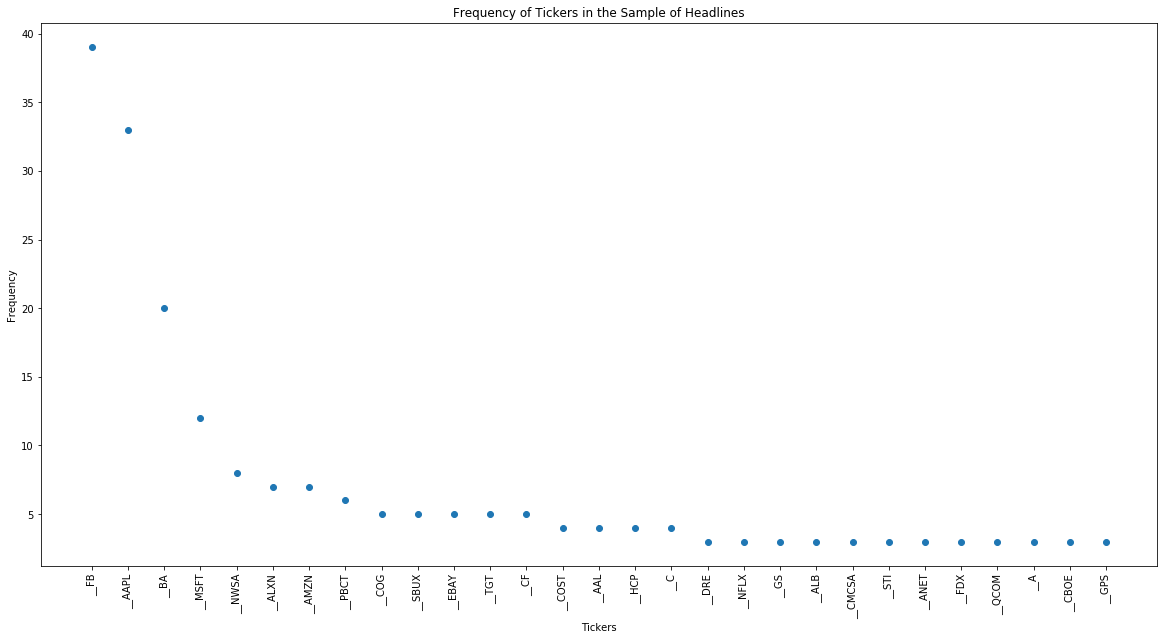

In [19]:
print(len(data))
print(data)
tickers_list = []
for x in data:
    if (x['Tick_Type'] == 'sub')&(x['final_vector'] is not None):
        tickers_list.append(x['Sub'])
    elif (x['Tick_Type'] == 'obj')&(x['final_vector'] is not None):
        tickers_list.append(x['Obj'])

#print(tickers_list)

from collections import Counter
counts = dict(Counter(tickers_list))

to_parse = {'tickers': [], 'counts': []}
for ticker, count in counts.items():
    to_parse['tickers'].append(ticker)
    to_parse['counts'].append(count)
print(to_parse)
    

ticker_counts = pd.DataFrame(to_parse)
ticker_counts = ticker_counts.sort_values(by = 'counts', ascending = False)
ticker_counts1 = ticker_counts[ticker_counts['counts']>2]

plt.figure(figsize = [20,10])
plt.scatter(ticker_counts1['tickers'], ticker_counts1['counts'])
plt.xticks(rotation = 'vertical')
plt.title('Frequency of Tickers in the Sample of Headlines')
plt.xlabel('Tickers')
plt.ylabel('Frequency')
plt.savefig('Tickers_Frequency', dpi = 1000)



# plt.figure(figsize = [20,10])
# plt.scatter(ticker_counts1['tickers'], ticker_counts1['counts'])
# plt.xticks(rotation = 'vertical')
#print(json.dumps(counts, indent = 2))
ticker_counts.head()

# plt.figure(figsize=(10,5))
# chart = sns.countplot(
#     data = ticker_counts,
#     x='tickers',
#     y = 'counts',
#     palette='Set1'
# )
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

# Clustering phrases vectors

In [20]:
relevant_data = [x for x in data if x['final_vector'] is not None]

In [21]:
# vocab = [x['final_vector'] for x in data if x['final_vector'] is not None]

vocab = [x['final_vector'] for x in relevant_data]
num_clusters = 100
kmeans = cluster.KMeans(n_clusters = num_clusters)
kmeans.fit(vocab)
print(len(vocab))

399


# Mapping

In [22]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(len(labels))
# print(centroids)

399


In [23]:
for i in range(len(relevant_data)):
    relevant_data[i]['cluster_label'] = labels[i]

In [24]:
n_neighbors = 5
y = labels

h = .02  # step size in the mesh

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm = 'ball_tree')
    clf.fit(vocab, y)

In [25]:
print(clf.fit(vocab, y))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')


In [26]:
A = clf.kneighbors([vocab[2]],n_neighbors)
A
# print(type([vocab[2]]))

(array([[ 0.        , 12.49463879, 21.69434396, 21.8710624 , 21.91262976]]),
 array([[  2, 342,  86, 236, 350]]))

In [27]:
# Create a Dataframe with the 100 clusters with 5 representatives for the verb 
# and 5 for the object of each

columns_verbs = ['Cluster No','Verb1','Verb2','Verb3','Verb4','Verb5','Obj1','Obj2','Obj3','Obj4','Obj5']

clusters_table = pd.DataFrame(columns = columns_verbs)

for i in range(len(centroids)):
    centroid_Verb_Obj = np.split(centroids[i],2) #each vector is just the concatenation of verb and obj vectors
    similar_centroid_Verb = model.wv.similar_by_vector(centroid_Verb_Obj[0],5)
    similar_centroid_Obj = model.wv.similar_by_vector(centroid_Verb_Obj[1],5)
    
    list_similar_verb = [i]
    list_similar_obj = []
    
    for j in range(5):
        list_similar_verb.append(similar_centroid_Verb[j][0])
        list_similar_obj.append(similar_centroid_Obj[j][0])
    list_cluster = list_similar_verb + list_similar_obj
    clusters_table.loc[len(clusters_table)] = list_cluster
print(clusters_table)
clusters_table.to_csv('Clusters_dictionary.csv')

   Cluster No    Verb1     Verb2     Verb3       Verb4        Verb5  \
0           0    FALLS     RISES  DECLINES   INCREASES        DROPS   
1           1    TURNS   BECOMES     PLAYS      LEAVES       SPELLS   
2           2     HOPE     SAVED  REALISED     THOUGHT      REALISE   
3           3     MAKE    MAKING      MADE       MAKES   ACCOMPLISH   
4           4     CUTS         S     HIKES  REDUCTIONS          CUT   
..        ...      ...       ...       ...         ...          ...   
95         95    URGED    URGING  APPEALED       VOWED      PLEDGED   
96         96  DELIVER   ACHIEVE  GENERATE     PROVIDE  DEMONSTRATE   
97         97   BECOME  BECOMING    BECAME     BECOMES        PROVE   
98         98    WANTS    WANTED     FAILS       TRIES      DECIDES   
99         99      TRY      FAIL      URGE       TRIED       TRYING   

         Obj1       Obj2        Obj3      Obj4         Obj5  
0    FORECAST  ESTIMATES   FORECASTS  ESTIMATE  PROJECTIONS  
1     BECOMES      TURN

# Returns study

In [28]:
returnsdf = pd.read_csv('data/returns/returnsSP500.csv')
returnsdf

# print(len(returnsdf.columns))
# print('GOOG' in returnsdf.columns)

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
0,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,-0.076389,NaN,NaN,-0.084310,NaN,-0.068273,-0.023973,-0.028571,NaN,...,0.023026,-0.022727,-0.019154,0.000000,-0.046512,NaN,-0.020100,NaN,-0.048423,NaN
2,2000-01-05,-0.062030,NaN,NaN,0.014634,NaN,0.077586,0.010526,-0.001838,NaN,...,0.038585,-0.021888,0.054516,0.017287,0.051490,NaN,0.005128,NaN,-0.001183,NaN
3,2000-01-06,-0.038076,NaN,NaN,-0.086538,NaN,0.076000,0.001736,0.034991,NaN,...,-0.009288,-0.086713,0.051698,0.001307,-0.020619,NaN,-0.008503,NaN,0.014218,NaN
4,2000-01-07,0.083333,NaN,NaN,0.047368,NaN,0.130112,-0.005199,0.010676,NaN,...,0.000000,0.113323,-0.002935,-0.002611,0.023684,NaN,-0.022298,NaN,0.002336,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5008,2019-11-27,0.001606,-0.003442,0.010758,0.013432,0.006954,0.007513,0.013024,0.000000,0.001642,...,0.006211,0.023126,-0.000582,0.001227,0.013055,0.005962,0.008922,0.011735,0.008256,-0.002133
5009,2019-11-29,-0.003823,-0.007254,-0.010707,-0.002203,-0.006793,-0.006779,-0.003100,0.000351,-0.000447,...,-0.001137,-0.006106,-0.008297,-0.009981,0.003351,-0.001288,0.000298,-0.008734,-0.005792,-0.009126
5010,2019-12-02,-0.005200,-0.022965,-0.003374,-0.011562,-0.007979,-0.000910,-0.020186,-0.011001,-0.007805,...,-0.004716,-0.027053,0.004257,0.002830,-0.011045,-0.012385,-0.001093,-0.005644,-0.005625,-0.005061
5011,2019-12-03,-0.003111,-0.028134,-0.025168,-0.017830,-0.012410,-0.004554,-0.005567,-0.001775,-0.004209,...,0.004248,-0.017946,-0.007892,0.007584,-0.006494,-0.013194,-0.011038,-0.007338,-0.018788,0.005171


In [29]:
params = pd.read_csv('data/SP500_parameters.csv')
params['Ticker_b']=params['Ticker']
params['Ticker']='__'+params['Ticker']
params
# params.loc[50:100,'Ticker_b']


,Ticker,Beta,Name,GICS,Ticker_b
0,__A,1.165846,Agilent Technologies Inc,Health Care,A
1,__AAL,1.570904,American Airlines Group,Industrials,AAL
2,__AAP,0.680250,Advance Auto Parts,Consumer Discretionary,AAP
3,__AAPL,1.488606,Apple Inc.,Information Technology,AAPL
4,__ABBV,0.889469,AbbVie Inc.,Health Care,ABBV
...,...,...,...,...,...
496,__XYL,1.096964,Xylem Inc.,Industrials,XYL
497,__YUM,0.484074,Yum! Brands Inc,Consumer Discretionary,YUM
498,__ZBH,0.901953,Zimmer Biomet Holdings,Health Care,ZBH
499,__ZION,1.049443,Zions Bancorp,Financials,ZION


In [30]:
ticker_counts.columns=['Ticker','count']
ticker_counts = ticker_counts.merge(params[['Ticker','GICS']],on = 'Ticker')

## Which industries are the most tackled by headlines 
##### in order to have enough data to study

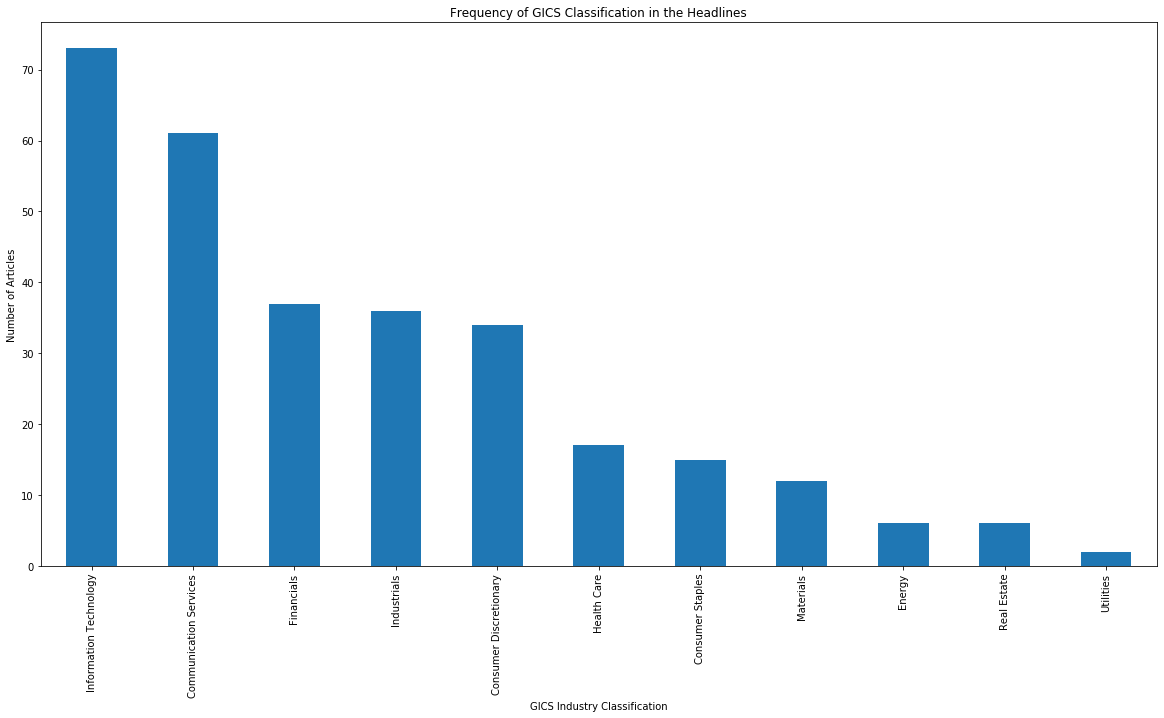

In [31]:
GICS_count = ticker_counts.groupby(['GICS']).agg(['sum'])
GICS_count =GICS_count.sort_values(by = ('count','sum'),ascending=False)


plt.figure(figsize = [20,10])
GICS_count[('count','sum')].plot(kind='bar')

plt.xlabel('GICS Industry Classification')
plt.ylabel('Number of Articles')
plt.title('Frequency of GICS Classification in the Headlines')
plt.savefig('GICS_Frequency', dpi = 1000)


In [32]:
industries = set(params['GICS'].values)

dataframe_industry_dict = {}
for industry in industries:
    industry_tickers = params.loc[params['GICS'] == industry, 'Ticker']
    industry_tickers = industry_tickers.str.replace('__','')
    industry_tickers = industry_tickers.str.replace('.','-')
    
    industry_tickers = list(set(industry_tickers) & set(returnsdf.columns))
    df_industry = returnsdf[industry_tickers + ['Date']]
    
    df_industry['market_exp'] = df_industry[industry_tickers].mean(axis=1)
    df_industry = df_industry.iloc[1:,:]#.dropna()
    cols = df_industry.columns
    cols = cols[-2:].append(cols[:(len(cols)-2)])
    df_industry = df_industry[cols]
    dataframe_industry_dict[industry] = df_industry

dataframe_industry_dict['Financials']


/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Date,market_exp,IVZ,RF,PBCT,MSCI,TRV,TROW,JPM,MCO,...,RJF,CMA,NTRS,RE,PRU,CFG,HBAN,FITB,COF,AJG
1,2000-01-04,-0.035024,-0.016816,-0.029255,-0.002994,NaN,-0.013258,-0.030249,-0.027444,-0.028902,...,-0.035461,-0.041667,-0.065015,-0.002857,NaN,NaN,-0.030641,-0.042039,-0.062246,-0.045187
2,2000-01-05,-0.006698,-0.042189,-0.005479,0.006006,NaN,-0.007678,-0.001835,-0.006173,-0.017857,...,-0.011029,-0.002899,0.022517,0.065903,NaN,NaN,-0.025862,-0.014939,-0.023088,0.004115
3,2000-01-06,0.023833,-0.011905,0.002755,-0.008955,NaN,0.019342,0.029412,0.014197,0.000000,...,0.000000,0.029070,0.020725,0.045699,NaN,NaN,0.035398,0.035071,0.045790,-0.001793
4,2000-01-07,0.021625,0.037349,0.010989,-0.006024,NaN,0.039848,-0.007143,0.018373,0.024242,...,0.011152,-0.001412,0.012690,0.053985,NaN,NaN,0.008547,-0.006410,0.028249,0.038748
5,2000-01-10,-0.013937,-0.005807,-0.043478,-0.018182,NaN,-0.018248,0.010791,-0.017182,0.000000,...,0.007353,-0.032532,-0.025063,-0.004878,NaN,NaN,-0.042373,-0.026267,-0.012363,-0.036561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5008,2019-11-27,0.004481,0.008547,0.009042,0.006109,-0.006121,0.001171,0.007164,0.002962,-0.000882,...,0.010724,0.008960,0.008900,0.001432,0.000959,0.004157,0.010156,0.001985,0.010381,0.008322
5009,2019-11-29,-0.002879,-0.007910,-0.005974,0.001822,0.003912,-0.000877,-0.001213,-0.002272,0.000618,...,-0.007294,-0.007471,-0.004179,-0.005499,-0.003194,-0.004916,-0.002011,-0.003301,-0.002394,-0.000322
5010,2019-12-02,-0.008494,-0.015376,-0.001803,-0.011515,-0.010108,-0.010679,-0.010521,-0.002201,-0.006485,...,-0.017368,-0.004403,-0.006714,-0.009032,-0.007263,-0.003900,-0.004030,-0.002650,-0.007799,-0.011150
5011,2019-12-03,-0.014515,-0.034702,-0.011439,-0.009810,-0.008653,-0.004732,-0.012024,-0.012855,-0.001776,...,-0.002946,-0.016405,-0.011359,-0.011123,-0.027545,-0.014357,-0.012138,-0.020591,-0.010682,-0.009541


# LIBOR 3M importation

In [33]:
libor = pd.read_excel('data/LIBOR_3M.xlsx')
libor['LIBOR 3M'] = libor['LIBOR 3M']/100
libor['Date'] = pd.to_datetime(libor['Date'])
libor

,Date,LIBOR 3M
0,2010-01-01,0.002506
1,2010-01-04,0.002544
2,2010-01-05,0.002525
3,2010-01-06,0.002500
4,2010-01-07,0.002494
...,...,...
2481,2019-07-08,0.023377
2482,2019-07-09,0.023407
2483,2019-07-10,0.023395
2484,2019-07-11,0.023034


In [34]:
for industry in industries:
    test = dataframe_industry_dict[industry]
    test['Date'] = pd.to_datetime(test['Date'])
    test = test.merge(libor,on = 'Date')
    
    cols = test.columns
    cols = cols[-1:].append(cols[:(len(cols)-1)])
    test = test[cols]
    
    dataframe_industry_dict[industry] = test
    
dataframe_industry_dict['Financials']

,LIBOR 3M,Date,market_exp,IVZ,RF,PBCT,MSCI,TRV,TROW,JPM,...,RJF,CMA,NTRS,RE,PRU,CFG,HBAN,FITB,COF,AJG
0,0.002544,2010-01-04,0.018151,-0.006386,0.024575,0.002994,0.005660,-0.001003,0.021596,0.028318,...,0.021035,0.031451,0.002481,-0.002684,0.040394,NaN,0.008219,0.037949,0.018518,-0.007996
1,0.002525,2010-01-05,0.010028,0.005570,0.033210,0.005970,0.003752,-0.023690,0.011213,0.019370,...,0.016069,0.003607,-0.001333,-0.014511,0.019703,NaN,0.021739,0.026680,0.039437,-0.005374
2,0.002500,2010-01-06,0.003747,-0.020878,0.012500,-0.000593,-0.027103,-0.014189,-0.015633,0.005494,...,0.014193,0.022215,-0.014487,-0.000356,0.011745,NaN,0.026596,0.005775,0.005420,0.000450
3,0.002494,2010-01-07,0.019587,0.003046,0.088183,0.004751,0.068844,0.014393,-0.000739,0.019809,...,-0.005998,0.054330,0.009478,0.002019,0.016102,NaN,0.111399,0.060287,0.049498,-0.006301
4,0.002512,2010-01-08,0.001277,-0.005640,0.001621,0.004728,0.033553,-0.001439,-0.003881,-0.002456,...,-0.010861,-0.012731,0.004407,-0.001778,-0.013083,NaN,-0.016317,0.000903,-0.008639,0.002717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,0.023377,2019-07-08,-0.008997,-0.018121,-0.005260,-0.010000,-0.031326,-0.001882,-0.013222,-0.005463,...,-0.022778,-0.015073,-0.023957,0.000000,-0.008468,-0.008080,-0.013649,-0.010229,-0.007997,-0.002428
2393,0.023407,2019-07-09,0.004561,0.001943,0.011897,-0.001783,0.014061,-0.002276,0.007893,0.004253,...,0.016376,0.010712,-0.000873,0.011316,-0.002749,0.010955,0.008740,0.007128,0.005338,0.004316
2394,0.023395,2019-07-10,-0.005527,-0.009695,-0.016329,-0.011309,0.000000,-0.000782,-0.003369,-0.002911,...,-0.001999,-0.016105,-0.012774,0.003419,-0.008268,-0.027785,-0.009386,-0.021939,-0.023079,0.001102
2395,0.023034,2019-07-11,0.006526,-0.030837,0.011288,0.007224,0.009580,-0.005870,-0.001188,0.009556,...,0.006128,0.014969,0.010175,-0.005382,0.003871,0.016290,0.010204,0.014834,0.006100,0.005723


# Computation of abnormal returns

In [35]:
abret_dict = {}
for industry in industries:
    df_returns = dataframe_industry_dict[industry]
    capm = pd.DataFrame(df_returns['Date'])
    risk_free_rate = df_returns['LIBOR 3M']
    market_avg_returns = df_returns['market_exp']
    
    abret_dict[industry] = pd.DataFrame(df_returns['Date'])
    
    for col in df_returns.columns[3:]:
        col = col.replace('-', '.')
        
        beta = params.loc[params['Ticker_b'] == col]['Beta'].values[0]
        stock_returns = returnsdf[col.replace('.', '-')]
        
        capm[col] = risk_free_rate + beta*(market_avg_returns-risk_free_rate)
        
        abret_dict[industry][col] = stock_returns - capm[col]
        abret_dict[industry] = abret_dict[industry].where((pd.notnull(abret_dict[industry])), None)
        
abret_dict['Financials']

,Date,IVZ,RF,PBCT,MSCI,TRV,TROW,JPM,MCO,SIVB,...,RJF,CMA,NTRS,RE,PRU,CFG,HBAN,FITB,COF,AJG
0,2010-01-04,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2010-01-05,-0.028942,-0.040635,-0.0126947,None,-0.0208518,-0.0419493,-0.0374117,-0.0403121,-0.0792482,...,-0.0470149,-0.0520076,-0.0764217,-0.00879667,None,None,-0.0408471,-0.052255,-0.074012,-0.0535945
2,2010-01-06,-0.0462851,-0.00945118,0.00231325,None,-0.0110201,-0.00585995,-0.00990995,-0.0218341,-0.037259,...,-0.0150301,-0.0066977,0.0185403,0.062835,None,None,-0.0296389,-0.0187177,-0.027124,0.000637392
3,2010-01-07,-0.0362696,-0.0199102,-0.0277954,None,0.00530063,0.00601661,-0.00525102,-0.022735,-0.00507614,...,-0.0230617,0.00877116,-0.00200015,0.0354267,None,None,0.015406,0.0150577,0.0222459,-0.0176881
4,2010-01-08,0.0364175,0.0099342,-0.00735524,None,0.0381703,-0.00814484,0.0170855,0.0231927,0.00612231,...,0.0101263,-0.0026382,0.01164,0.0520342,None,None,0.00729907,-0.00765666,0.0272574,0.0372037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,2019-07-08,0.0441271,0.0361029,0.0149107,0.0356913,-0.00201783,0.0239841,0.0365538,0.0202399,0.051487,...,0.0348563,0.0176439,0.0359588,-0.00754236,0.04822,None,0.089176,0.0371601,0.0471191,0.0157432
2393,2019-07-09,-0.0216112,0.0144582,-9.30288e-05,0.0188371,-0.0119552,-0.00249003,-0.0427864,-0.0138477,-0.0366685,...,0.0139136,-0.0226166,-0.0204211,-0.0155197,-0.0151202,None,0.0503821,-0.0366348,-0.0270841,-0.0158918
2394,2019-07-10,0.0954126,0.0543253,0.0378166,0.0425757,0.0320421,0.0676896,0.0785762,0.0568442,0.0419214,...,0.0649247,0.0682777,0.0561336,0.0192592,0.105522,None,0.0733967,0.10105,0.0718456,0.0256091
2395,2019-07-11,-0.00835903,0.00136104,-0.0295256,-0.00756031,-0.0331682,0.0188695,-0.00694783,0.012503,0.00184354,...,0.0242275,0.00714874,0.00143773,-0.00601684,0.00615499,None,-0.0158194,-0.0200802,0.0544784,-0.00201518


In [36]:
# Define a lookup function to return, for a given ticker, 
# start_date and horizon, the cumulative average returns over that period

def lookup_cumul_returns(ticker, start_date, horizon):
    '''
    Args:
    start_date (pd.Timestamp)
    '''
    
    try:
        industry_classification = params.loc[params['Ticker_b'] == ticker, 'GICS'].values[0]
    except:
        print(ticker)
        return None
        
    relevant_df = abret_dict[industry_classification]
    
    start_index_values = relevant_df.loc[pd.to_datetime(relevant_df['Date']) >= pd.Timestamp(start_date),:].index.values
    
    if len(start_index_values) == 0:
        return None
    else:
        start_index = start_index_values[0]

    end_index = start_index + horizon
    
    if end_index > len(relevant_df):
        return None
    
    relevant_returns = relevant_df.loc[start_index + 1:end_index, ticker]
    
    to_return = relevant_returns.cumsum().values[-1] / horizon
    
    if np.isnan(to_return):
        return None
    
    else:
        return to_return

In [37]:
horizons = [3, 5, 10]

print(list(relevant_data[0].keys()))

# Add a column with the referenced ticker for each headline
for i, el in enumerate(relevant_data):
    lookup_col = el['Tick_Type']
    if lookup_col in ['sub', 'obj']:
        el['Ticker'] = el[lookup_col.capitalize()]
    else:
        el['Ticker'] = None
        
    relevant_data[i] = el
    
relevant_data = [x for x in relevant_data if x['Ticker'] is not None]
    
# {
#     3 {
#         'headlines': [(Sub, Verb, Obj), (), ...],
#         '3 day': [],
#         '5 day': []
#     }
# }

# Set up the data structure. Each entry looks like the above
cluster_labels = set([x['cluster_label'] for x in relevant_data])

cluster_sentiments = {}
for label in cluster_labels:
    cluster_sentiments[label] = {
        'svos': [],
        'headlines': [],
    }
    for horizon in horizons:
        cluster_sentiments[label]['{}_days'.format(horizon)] = []       
        
for el in relevant_data:
    svo = (el['Sub'], el['Verb'], el['Obj'])
    start_date = el['Date']
    ticker = el['Ticker'].replace('__', '')
    
    cluster_label = el['cluster_label']
    headline = el['Original Headline']
    
    cluster_sentiments[cluster_label]['svos'].append(svo)
    cluster_sentiments[cluster_label]['headlines'].append(headline)
    
    for horizon in horizons:
        horizon_cumul_returns = lookup_cumul_returns(ticker, start_date, horizon)
        cluster_sentiments[cluster_label]['{}_days'.format(horizon)].append(horizon_cumul_returns)        
        

['Date', 'Sub', 'Verb', 'Obj', 'Tick_Type', 'Headlines', 'Original Headline', 'final_vector', 'cluster_label']
HCP
HCP
HCP
HCP
HCP
HCP
HCP
HCP
HCP
HCP
HCP
HCP
CELG
CELG
CELG
CELG
CELG
CELG


In [38]:
parsed_sentiments = copy.deepcopy(cluster_sentiments)

for label in cluster_sentiments:
    for horizon in horizons:
        entries = cluster_sentiments[label]['{}_days'.format(horizon)]
        non_null_entries = [x for x in entries if x is not None]
        parsed_sentiments[label]['{}_days'.format(horizon)] = np.mean(non_null_entries)

# Remove any clusters which have all nan values
all_nan_labels = []
for label, contents in parsed_sentiments.items():
    all_nan = True
    for horizon in horizons:
        if not np.isnan(contents['{}_days'.format(horizon)]):
            all_nan = False
            break
            
    if all_nan:
        all_nan_labels.append(label)
        
for label in all_nan_labels:
    del parsed_sentiments[label]
        
cluster_labels = list(parsed_sentiments.keys())

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [39]:
for label, contents in parsed_sentiments.items():
    print('cluster {}'.format(label))
    for horizon in [3,5,10]:
#         print(contents)
        print(contents['{}_days'.format(horizon)])

cluster 0
0.00332494591776884
-0.002032874835138005
0.0016091506580845202
cluster 1
-0.0019351225615096002
-0.006638186250959024
-0.005225859329208169
cluster 2
-0.02200267680177042
-0.016911425687195385
-0.012256077551760293
cluster 4
-0.004369681214051688
0.004829930802067934
-0.0035292513037810586
cluster 5
0.0015544648388635296
0.0029535689725096667
0.001852883904308589
cluster 7
0.005287456379252172
0.007312714578121492
0.005100595778444288
cluster 8
-0.0006478230225876938
0.0012137648887324084
-0.001986631468667591
cluster 9
0.011369377511215412
0.009481918558105115
0.005150402935938901
cluster 10
0.003718141954588543
0.003994290642324589
-0.0016648110027343795
cluster 11
-0.026447986938302845
-0.011309751239018085
-0.015227900456770358
cluster 12
-0.02437781488939117
-0.010121803175424634
-0.002349999329765428
cluster 13
-0.0067334494655659355
-0.0035412732817485305
0.0032551053743181137
cluster 14
0.02191832907819848
0.013867184927504217
0.015146361845446526
cluster 15
0.005620

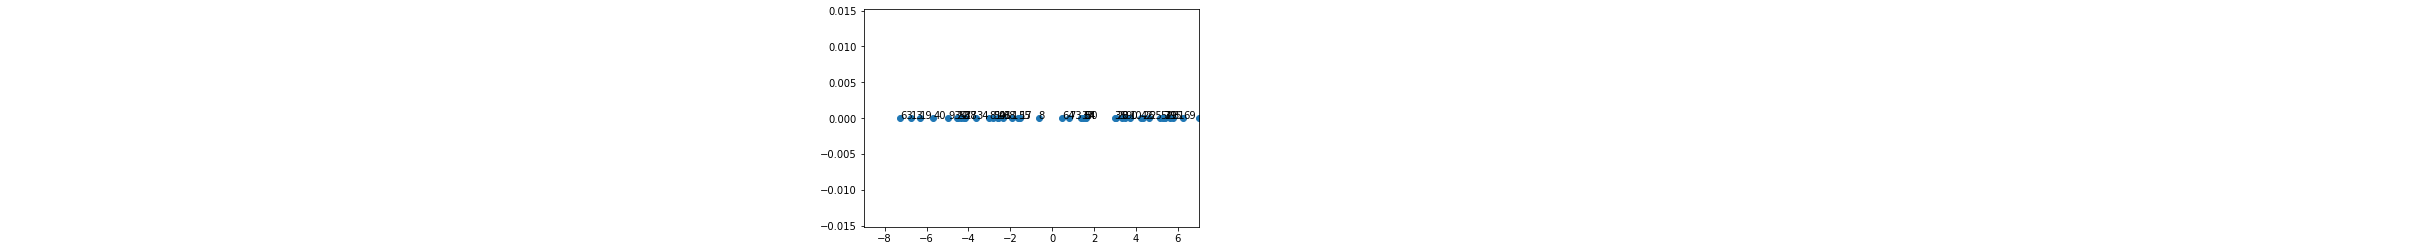

In [40]:
small_days_sentiment=[]
medium_days_sentiment = []
large_days_sentiment = []
for x in cluster_labels:
    small_days_sentiment.append(1000*parsed_sentiments[x]['3_days'])
    medium_days_sentiment.append(parsed_sentiments[x]['5_days'])
    large_days_sentiment.append(parsed_sentiments[x]['10_days'])

# fig,ax = plt.subplots(figsize = (20,4))
fig, ax = plt.subplots()
# fig(figsize = (20,20))
plt.scatter(small_days_sentiment,np.zeros(len(cluster_labels)))
label_graph=[str(list(cluster_labels)[i]) for i in range(len(cluster_labels))]
plt.xlim(-9,7)
for i,txt in enumerate(label_graph):
    ax.annotate(txt,(small_days_sentiment[i],np.zeros(len(cluster_labels))[i]))


## FORECASTING

In [41]:
def clean(headlines, stopwords):
    '''
    Args:
    headlines: pd.Series
    '''
    headlines = headlines.str.lower()
    
    headlines.replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\$&]','', inplace = True, regex=True)
    extensions_list = ['co','reuters','Reuters','bloomberg', 'may','also','could','would', 'na','&amp','gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase)

    stopwords = stopwords.union(set(extensions_list))

    wordlist = filter(None, " ".join(list(set(list(itertools.chain(*headlines.str.split(' ')))))).split(" "))

    headlines = [' '.join(filter(None,filter(lambda word: word not in stopwords, line))) for line in headlines.str.lower().str.split(' ')]
    
    return headlines

In [42]:
def closest_cluster_sentiment(headline, tickers):
    '''
    Returns the closest cluster to the new headline
    
    Args:
    headline (str)
    clusters (dict)
    '''
    
    n_neighors = 5
    
    # Get SVO of the new headline
    cleaned_headline = clean(pd.Series([headline]), stop)
    ticker_info = parse_header(cleaned_headline[0], tickers, None)
    
    headline_sentiment = {}
    
    headline_sentiment = {
        '3_days': [],
        '5_days': [],
        '10_days': []
    }
    
    if len(ticker_info) != 0:
        try :
            for ls in ticker_info:
                ticker_key = ls[3]

                if ticker_key == 'obj':
                    ticker = ls[2]
                    svo = [ls[0],ls[1]]
                    svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[0].upper()]))]

                if ticker_key == 'sub':
                    ticker = ls[0]
                    svo = [ls[1],ls[2]]
                    svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[2].upper()]))]


                close_neighbors = clf.kneighbors(svo_vec,n_neighbors)
                clusters_list = [labels[close_neighbors[1][0][i]] for i in range(n_neighors)]
                distances_list = [close_neighbors[0][0][i] for i in range(n_neighors)]

                closest_cluster_label = clusters_list[0]
                for horizon in horizons:
                    closest_cluster_horizon_sentiment = parsed_sentiments[closest_cluster_label]['{}_days'.format(horizon)]
                    headline_sentiment['{}_days'.format(horizon)] = closest_cluster_horizon_sentiment
                
        except:
            return None
                
    return headline_sentiment

In [43]:
def inverse_distance_sentiment(headline, parsed_sentiments, tickers, labels, horizons):
    '''
    Returns the closest cluster to the new headline
    
    Args:
    headline (str)
    clusters (dict)
    tickers (dict): list of company name: ticker pairs
    horizons (iterable): iterable of horizon lengths to consider
    '''
    p = 2
    n_neighbours = len(labels)
    
    # Get SVO of the new headline
    cleaned_headline = clean(pd.Series([headline]), stop)
    ticker_info = parse_header(cleaned_headline[0], tickers, None)
    
    headline_sentiment = {'{}_days'.format(horizon): [] for horizon in horizons}
    
    if len(ticker_info) == 0:
        return None
    try :
        for ls in ticker_info:
            ticker_key = ls[3]

            if ticker_key == 'obj':
                ticker = ls[2]
                svo = [ls[0],ls[1]]
                svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[0].upper()]))]

            elif ticker_key == 'sub':
                ticker = ls[0]
                svo = [ls[1],ls[2]]
                svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[2].upper()]))]

            else:
                # Skip if this is a subobj ticker label
                continue

            neighbours = clf.kneighbors(svo_vec, n_neighbours)
            clusters_list = list(set([labels[neighbours[1][0][i]] for i in range(n_neighbours)]) & set(list(parsed_sentiments.keys())))
            distances_list = [neighbours[0][0][i] for i in range(n_neighbours)]

            new_clusters_list = []
            new_distances_list = []

            for index, label in enumerate(clusters_list):
                if label in parsed_sentiments:
                    new_clusters_list.append(clusters_list[index])
                    new_distances_list.append(distances_list[index])


            distances_list = new_distances_list
            clusters_list = new_clusters_list
            
            #### NOTE! This is not correct

            for horizon in horizons:
                if 0 in distances_list :
                    headline_sentiment['{}_days'.format(horizon)] = parsed_sentiments[clusters_list[0]]['{}_days'.format(horizon)]
                else:
                    weights = np.array(list(map(lambda x: x**(-p), np.array(distances_list))))
                    sentiments = [parsed_sentiments[i]['{}_days'.format(horizon)] for i in clusters_list]
                    
                    if len(sentiments) == 0:
                        print(headline)
                    
                    if len(weights) == 0:
                        print(headline)
                        
                    headline_sentiment['{}_days'.format(horizon)] = np.average(sentiments, weights = weights)
                    
                    print(headline_sentiment['{}_days'.format(horizon)])
                    
                    if np.isnan(headline_sentiment['{}_days'.format(horizon)]):
                        print('was nan before')
                        headline_sentiment['{}_days'.format(horizon)] = None

    except:
        print('exception')
        return None
    
    all_empty = True
    for val in headline_sentiment.values():
        if type(val) == np.float64:
            all_empty = False
            break
            
    if all_empty:
        print('all empty')
        return None

    return headline_sentiment


In [44]:
testing_output = []

for index in test_data.index:
    date = test_data.loc[index, 'Date']
    headline = test_data.loc[index, 'Headlines']
    
    if test_data.loc[index, 'Tick_Type'] == 'obj':
        ticker = test_data.loc[index, 'Obj']
    if test_data.loc[index, 'Tick_Type'] == 'sub':
        ticker = test_data.loc[index, 'Sub']
#     else:
#         ticker = None
    info = {
        'date': date,
        'headline': headline,
        'ticker' : ticker
    }
    
# The following horizon_sentiments is constructed using Shephard's method of inverse distance
    
    horizon_sentiments = inverse_distance_sentiment(
        headline = headline,
        parsed_sentiments = parsed_sentiments,
        tickers = tickers,
        labels = labels,
        horizons = horizons
    )

# The following horizon_sentiments is constructed assigning 
# the value of the sentiment of the closest cluster only

#     horizon_sentiments = closest_cluster_sentiment(
#         headline = headline,
#         tickers = tickers
#     )
    
    if horizon_sentiments is not None:
        for horizon in horizons:
            info['{}_days'.format(horizon)] = horizon_sentiments['{}_days'.format(horizon)]
            
        testing_output.append(info)

exception
exception
exception
exception
exception
0.00016641678106366583
1.569896664681758e-05
-0.00014558518696040841
exception
exception
exception
all empty
exception
0.00024287435961373047
-5.933035579775146e-05
-0.00018363660192371973
0.00024287435961373047
-5.933035579775146e-05
-0.00018363660192371973
exception
0.00026995732322309215
-2.042374773607505e-05
-0.0001459159840584603
exception
0.00030715471416864406
5.4976928735885645e-05
-0.00010325320319184895
exception
exception
exception
exception
exception
exception
exception
6.215993688851967e-05
-6.753668624116463e-06
-0.00014214742315731986
all empty
-0.0003052578184098898
-0.0003486200117546682
-0.0005166764994015876
exception
exception
exception
0.00015278943210614185
-5.5663355188542605e-06
-0.00014588160487307697
exception
exception
exception
exception
exception
exception
-0.00048095798618145015
-0.00018616104361966561
-0.00030093744472756514
exception
exception
0.0003476834087493065
6.806383611609527e-05
-9.57355881191714

In [45]:
testing_df = pd.DataFrame(testing_output)
testing_df.head(10)

,date,headline,ticker,3_days,5_days,10_days
0,2018-11-26,fedex declares quarterly dividend per share – ...,__FDX,0.003325,-0.002033,0.001609
1,2018-12-01,boeing donates bush institutes military servic...,__BA,0.000166,0.000016,-0.000146
2,2018-12-05,flipkart investors force walmart take company ...,__WMT,0.000243,-0.000059,-0.000184
3,2018-12-05,flipkart investors force walmart take company ...,__WMT,0.000243,-0.000059,-0.000184
4,2018-12-07,comcast raises offer sky bid edge rupert murdo...,__CMCSA,0.000270,-0.000020,-0.000146
5,2018-12-07,apple announces million china clean energy fund,__AAPL,0.000307,0.000055,-0.000103
6,2018-12-18,banks banned charging ripoff overdraft fees fc...,__STI,0.000062,-0.000007,-0.000142
7,2018-12-19,boeing opens first completion plant china amid...,__BA,-0.000305,-0.000349,-0.000517
8,2018-12-27,turkish airlines mandates aviation capital fin...,__AAL,0.000153,-0.000006,-0.000146
9,2019-01-15,apple rumoured replacing iphone chargers andro...,__AAPL,-0.000481,-0.000186,-0.000301


In [46]:
for horizon in horizons:
    for i in testing_df.index:
        date = testing_df.loc[i,'date']
        ticker = testing_df.loc[i,'ticker']
        ticker = ticker.replace('__','')
        cumul = lookup_cumul_returns(ticker, date, horizon)
        #print(cumul)
        testing_df.loc[i,str(horizon)+'_days_actual'] = cumul
        
testing_df = testing_df.dropna()
testing_df

,date,headline,ticker,3_days,5_days,10_days,3_days_actual,5_days_actual,10_days_actual
0,2018-11-26,fedex declares quarterly dividend per share – ...,__FDX,0.003325,-0.002033,0.001609,0.003130,0.011556,0.006350
1,2018-12-01,boeing donates bush institutes military servic...,__BA,0.000166,0.000016,-0.000146,0.049193,0.019641,0.019625
2,2018-12-05,flipkart investors force walmart take company ...,__WMT,0.000243,-0.000059,-0.000184,-0.016864,-0.012879,-0.006977
3,2018-12-05,flipkart investors force walmart take company ...,__WMT,0.000243,-0.000059,-0.000184,-0.016864,-0.012879,-0.006977
4,2018-12-07,comcast raises offer sky bid edge rupert murdo...,__CMCSA,0.000270,-0.000020,-0.000146,-0.026880,-0.005783,-0.004370
5,2018-12-07,apple announces million china clean energy fund,__AAPL,0.000307,0.000055,-0.000103,-0.007017,-0.002606,0.012958
6,2018-12-18,banks banned charging ripoff overdraft fees fc...,__STI,0.000062,-0.000007,-0.000142,-0.003878,-0.007421,-0.002802
7,2018-12-19,boeing opens first completion plant china amid...,__BA,-0.000305,-0.000349,-0.000517,0.020537,0.004319,0.009610
8,2018-12-27,turkish airlines mandates aviation capital fin...,__AAL,0.000153,-0.000006,-0.000146,0.046104,0.048434,0.006828
9,2019-01-15,apple rumoured replacing iphone chargers andro...,__AAPL,-0.000481,-0.000186,-0.000301,0.027103,0.029828,0.016671


In [47]:
for horizon in horizons:
    testing_df[str(horizon)+'_dir_comparison'] = testing_df[str(horizon)+'_days_actual']*testing_df[str(horizon)+'_days']
  

testing_df 

,date,headline,ticker,3_days,5_days,10_days,3_days_actual,5_days_actual,10_days_actual,3_dir_comparison,5_dir_comparison,10_dir_comparison
0,2018-11-26,fedex declares quarterly dividend per share – ...,__FDX,0.003325,-0.002033,0.001609,0.003130,0.011556,0.006350,1.040795e-05,-2.349109e-05,1.021834e-05
1,2018-12-01,boeing donates bush institutes military servic...,__BA,0.000166,0.000016,-0.000146,0.049193,0.019641,0.019625,8.186494e-06,3.083509e-07,-2.857135e-06
2,2018-12-05,flipkart investors force walmart take company ...,__WMT,0.000243,-0.000059,-0.000184,-0.016864,-0.012879,-0.006977,-4.095813e-06,7.640868e-07,1.281323e-06
3,2018-12-05,flipkart investors force walmart take company ...,__WMT,0.000243,-0.000059,-0.000184,-0.016864,-0.012879,-0.006977,-4.095813e-06,7.640868e-07,1.281323e-06
4,2018-12-07,comcast raises offer sky bid edge rupert murdo...,__CMCSA,0.000270,-0.000020,-0.000146,-0.026880,-0.005783,-0.004370,-7.256496e-06,1.181012e-07,6.376445e-07
5,2018-12-07,apple announces million china clean energy fund,__AAPL,0.000307,0.000055,-0.000103,-0.007017,-0.002606,0.012958,-2.155173e-06,-1.432508e-07,-1.337935e-06
6,2018-12-18,banks banned charging ripoff overdraft fees fc...,__STI,0.000062,-0.000007,-0.000142,-0.003878,-0.007421,-0.002802,-2.410444e-07,5.011588e-08,3.983321e-07
7,2018-12-19,boeing opens first completion plant china amid...,__BA,-0.000305,-0.000349,-0.000517,0.020537,0.004319,0.009610,-6.269206e-06,-1.505624e-06,-4.965406e-06
8,2018-12-27,turkish airlines mandates aviation capital fin...,__AAL,0.000153,-0.000006,-0.000146,0.046104,0.048434,0.006828,7.044201e-06,-2.696001e-07,-9.960969e-07
9,2019-01-15,apple rumoured replacing iphone chargers andro...,__AAPL,-0.000481,-0.000186,-0.000301,0.027103,0.029828,0.016671,-1.303518e-05,-5.552794e-06,-5.016965e-06


In [48]:
direction_test = testing_df
direction_result_dict ={}
for horizon in horizons :
    pos = len(direction_test.loc[direction_test[str(horizon)+'_dir_comparison']>0,:])
    tot = len(direction_test)
    direction_result_dict[horizon]=pos/tot
    
direction_result_dict
    

{3: 0.358974358974359, 5: 0.4358974358974359, 10: 0.48717948717948717}

In [49]:
magnitude_test = testing_df

for horizon in horizons :
    magnitude_test[str(horizon)+'_rel_gap']= abs(magnitude_test[str(horizon)+'_days_actual']-magnitude_test[str(horizon)+'_days'])/magnitude_test[str(horizon)+'_days_actual']
    
magnitude_test

,date,headline,ticker,3_days,5_days,10_days,3_days_actual,5_days_actual,10_days_actual,3_dir_comparison,5_dir_comparison,10_dir_comparison,3_rel_gap,5_rel_gap,10_rel_gap
0,2018-11-26,fedex declares quarterly dividend per share – ...,__FDX,0.003325,-0.002033,0.001609,0.003130,0.011556,0.006350,1.040795e-05,-2.349109e-05,1.021834e-05,0.062194,1.175921,0.746596
1,2018-12-01,boeing donates bush institutes military servic...,__BA,0.000166,0.000016,-0.000146,0.049193,0.019641,0.019625,8.186494e-06,3.083509e-07,-2.857135e-06,0.996617,0.999201,1.007418
2,2018-12-05,flipkart investors force walmart take company ...,__WMT,0.000243,-0.000059,-0.000184,-0.016864,-0.012879,-0.006977,-4.095813e-06,7.640868e-07,1.281323e-06,-1.014402,-0.995393,-0.973682
3,2018-12-05,flipkart investors force walmart take company ...,__WMT,0.000243,-0.000059,-0.000184,-0.016864,-0.012879,-0.006977,-4.095813e-06,7.640868e-07,1.281323e-06,-1.014402,-0.995393,-0.973682
4,2018-12-07,comcast raises offer sky bid edge rupert murdo...,__CMCSA,0.000270,-0.000020,-0.000146,-0.026880,-0.005783,-0.004370,-7.256496e-06,1.181012e-07,6.376445e-07,-1.010043,-0.996468,-0.966609
5,2018-12-07,apple announces million china clean energy fund,__AAPL,0.000307,0.000055,-0.000103,-0.007017,-0.002606,0.012958,-2.155173e-06,-1.432508e-07,-1.337935e-06,-1.043776,-1.021099,1.007968
6,2018-12-18,banks banned charging ripoff overdraft fees fc...,__STI,0.000062,-0.000007,-0.000142,-0.003878,-0.007421,-0.002802,-2.410444e-07,5.011588e-08,3.983321e-07,-1.016030,-0.999090,-0.949274
7,2018-12-19,boeing opens first completion plant china amid...,__BA,-0.000305,-0.000349,-0.000517,0.020537,0.004319,0.009610,-6.269206e-06,-1.505624e-06,-4.965406e-06,1.014863,1.080721,1.053763
8,2018-12-27,turkish airlines mandates aviation capital fin...,__AAL,0.000153,-0.000006,-0.000146,0.046104,0.048434,0.006828,7.044201e-06,-2.696001e-07,-9.960969e-07,0.996686,1.000115,1.021365
9,2019-01-15,apple rumoured replacing iphone chargers andro...,__AAPL,-0.000481,-0.000186,-0.000301,0.027103,0.029828,0.016671,-1.303518e-05,-5.552794e-06,-5.016965e-06,1.017746,1.006241,1.018051


In [50]:
magnitude_test.mean()

3_days               2.403910e-04
5_days              -1.033556e-04
10_days             -1.191010e-04
3_days_actual        3.168460e-03
5_days_actual        6.237820e-03
10_days_actual       4.993510e-03
3_dir_comparison    -6.383603e-07
5_dir_comparison    -1.651694e-06
10_dir_comparison   -6.387306e-07
3_rel_gap           -1.669003e-01
5_rel_gap            3.279288e-02
10_rel_gap           2.100282e-01
dtype: float64

In [51]:
magnitude_test.std()

3_days               0.000571
5_days               0.000343
10_days              0.000307
3_days_actual        0.022314
5_days_actual        0.019429
10_days_actual       0.010896
3_dir_comparison     0.000006
5_dir_comparison     0.000005
10_dir_comparison    0.000003
3_rel_gap            0.991004
5_rel_gap            1.020682
10_rel_gap           0.973888
dtype: float64